# Overfitting and Underfitting

Models too complex for the data overfit:
* they explain too well the data that they have seen
* they do not generalize

Models too simple for the data underfit:
* they capture no noise
* they are limited by their expressivity

How to find the right trade-off?

In [1]:
# # Standard imports
import pandas as pd
import numpy as np

# Disable jedi autocompleter
%config Completer.use_jedi = False

## The Framework and why do we need it

In this section we intend to go into details into the cross-validation framework.  
Before we dive in, let's linger on the reasons for always having training and testing sets. Let’s first look at the limitation of using a dataset without keeping any samples out.

To illustrate the different concepts, we will use the California housing dataset.

In [2]:
from sklearn.datasets import fetch_california_housing

In [3]:
housing = fetch_california_housing(as_frame=True)
type(housing)

sklearn.utils.Bunch

In [4]:
dir(housing)

['DESCR', 'data', 'feature_names', 'frame', 'target', 'target_names']

In [5]:
data = housing.data
target = housing.target
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


To simplify future visualtization, let's transform the prices from the 100 (k\\$) range to the thousand dollars (k\\$) range.

In [6]:
target *= 100
target.head()

0    452.6
1    358.5
2    352.1
3    341.3
4    342.2
Name: MedHouseVal, dtype: float64

## Training Error vs. Testing Error

To solve this regression task, we will use a decision tree regressor

In [7]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(data, target)

DecisionTreeRegressor(random_state=0)

After training the regressor, we sould like to know it potential generalization performance once deployed in production. For this purpose, we use the <code style="background:yellow;color:black">mean absolute error</code>, which gives us an error in the native unit, i.e. k\\$.

In [8]:
from sklearn.metrics import mean_absolute_error

target_predicted = regressor.predict(data)
score = mean_absolute_error(target, target_predicted)
print(f"On average, our regressor makes an error of {score:.2f} k$")

On average, our regressor makes an error of 0.00 k$


We get a perfect prediction with no errors. It is too optimistic and almost always revealing a methodological problem when doing machine learning.

<div class="alert alert-block alert-info">
Indeed, we trained and predicted on the same dataset. Since our decision tree was fully grown, every sample in the dataset is stored in a leaf node. Therefore, our decision tree fully memorized the dataset given during <em>fit</em> and therefore made no error when predicting.</div>

This error computed above is called the <code style="background:yellow;color:black">empirical error or training error</code>.

We trained a predictive model to minimize the training error but our aim is to minimize the error on data that has not been seen during training.

This error is also called the <code style="background:yellow;color:black">generalization error or the "true" testing error</code>.

Thus the most basic evaluation involves:

* splitting our dataset into two subsets: a training set and a testing set;
* fitting the model on the training set;
* estimating the training error on the trainin set;
* estimating the testing error on the testing set.

So let's split our dataset:

In [9]:
from sklearn.model_selection import train_test_split                                                                    

<div class="alert alert-block alert-info">
<b>Side Note: </b>It is better to keep your imports in one cell, and the code in the next one, in order to use the helper keyboard shortcut [shift] + [tab], in case you don't know what input parameters are required.</div>

In [10]:
data_train, data_test, target_train, target_test = train_test_split(data, target, 
                                                                    random_state=0)

Then, let's train our model using the `data_train` and `target_train`.

In [11]:
regressor.fit(data_train, target_train)

DecisionTreeRegressor(random_state=0)

Finally, we estimate the different types of errors.

In [12]:
# Let's start with the training error
target_predicted = regressor.predict(data_train)
score = mean_absolute_error(target_train, target_predicted)
print(f"The training error of our model is {score:.2f} k$")

The training error of our model is 0.00 k$


We observe the same phenomena as before: our model memorized the training set. However, we now compute the testing error.

In [13]:
target_predicted = regressor.predict(data_test)
score = mean_absolute_error(target_test, target_predicted)
print(f"The testing error of our model is {score:.2f} k$")

The testing error of our model is 47.28 k$


<div class="alert alert-block alert-info">
This testing error is actually about what we would expect from our model if it was used in a production environment.</div>

## Stability of the Cross-Validation Estimates

When doing a single train-test split we don't give any idication regarding the robustness of the evaluation of our predictive model: in particular, if the test set is small, this estimate of the testing error will be unstable and wouldn't reflect the "true error rate" we would have observed with the same model on an unlimited amount of test data.

**Coss-Validation** allows estimating the robustness of apredictive model by repeating the splitting procedure. It will give several training and testing errors and thus some <code style="background:yellow;color:black">estimate of the variability of the model generalization performance.</code>

There are different cross-validation strategies, for now we are going to focus on one called "shuffle-split". At each iteration of this strategy we:

  * randomly shuffle the order of the samples of a copy of the full dataset;
  * split the shuffled dataset into a train and a test set;
  * train a new model on the train set;
  * evaluate the testing error on the test set.


We repeat this procedure `n_splits` times. Using `n_splits=40` means that we will train 40 models in total and all of the will be discarded: we just record their generalization performance on each variant of the test set.

To evaluate the generalization performance of our regressor, we can use `sklearn.model_selection.cross_validate` with `sklearn.model_selection.ShuffleSplit` object:

In [14]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

In [15]:
cv = ShuffleSplit(n_splits=40, test_size=.3, random_state=0)
results = cross_validate(regressor, data, target,
                         cv=cv, scoring='neg_mean_absolute_error')

The results `results` are stored into a Python dictionary. We will convert it into a pandas `DataFrame`

In [16]:
results = pd.DataFrame(results)
results.head()

,fit_time,score_time,test_score
0,0.212744,0.004829,-46.909797
1,0.159125,0.004656,-46.421170
2,0.150409,0.004520,-47.411089
3,0.203748,0.004383,-44.319824
4,0.136777,0.004277,-47.607875


<div class="alert alert-block alert-info">
<b>Tip:</b>
    
A score is a metric for which higher values mean better results. On the contrary, an error is a metric for which lower values mean better results. The parameter `scoring` in `cross_validate` always expect a function that is a score.  
    
To make it easy, all error metrics in scikit-learn, like `mean_absolute_error`, can be transformed into a score to be used in `cross_validate`. To do so, you need to pass a string of the error metric with an additional `neg_` string at the front to the parameter `scoring`; for instance `scoring="neg_mean_absolute_error"`. In this case, the negative of the mean absolute error will be computed which would be equivalent to a score.
</div>

In other words: Adding `neg_` to an error name convert it to a score!

Let us revert the negation to get the actual error:

In [17]:
results['test_error'] = -results['test_score']

Let's check the results reported by the cross-validation.

In [18]:
results.head()

,fit_time,score_time,test_score,test_error
0,0.212744,0.004829,-46.909797,46.909797
1,0.159125,0.004656,-46.421170,46.421170
2,0.150409,0.004520,-47.411089,47.411089
3,0.203748,0.004383,-44.319824,44.319824
4,0.136777,0.004277,-47.607875,47.607875


Let's display the testing error distribution and thus, have an estimate of its variability.

In [19]:
import matplotlib.pyplot as plt

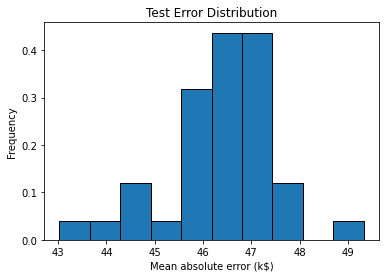

In [20]:
results['test_error'].plot.hist(bins=10, edgecolor="black", density=True)
plt.xlabel("Mean absolute error (k$)")
plt.title("Test Error Distribution");

We observe that the testing error is clustered around 47 k\\$ and ranges from 43 k\\$ to 50 k\\$.

In [21]:
print(f"The mean cross-validated testing error is: "
      f"{results['test_error'].mean():.2f} k$")

The mean cross-validated testing error is: 46.36 k$


In [22]:
print(f"The standard deviation of the testing error is: "
      f"{results['test_error'].std():.2f} k$")

The standard deviation of the testing error is: 1.17 k$


If we were to train a single model on the full dataset (without cross-validation) and then later had access to an unlimited amount of test data, we would expect its true testing error to fall close to that region.

While this information is interesting in itself, it should be contrasted to the scale of the natural variability of the vector `target` in our dataset.

Let us plot the distribution of the target variable:

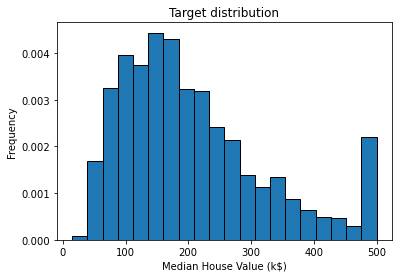

In [23]:
target.plot.hist(bins=20, edgecolor="black", density=True)
plt.xlabel("Median House Value (k$)")
plt.title("Target distribution");

In [24]:
print(f"The standard deviation of the target is: {target.std():.2f} k$")

The standard deviation of the target is: 115.40 k$


## More Detail Regarding `cross_validate`

During cross-validation, many models are trained and evaluated. Indeed, the number of elements in each array of the output of `cross_validate` is a result from one of these `fit/score` procedures. To make it explicit, it is possible to retrieve these fitted models for each of the splits/folds by passing the option `return_estimator=True in cross_validate`.

In [26]:
results = cross_validate(regressor, data, target, return_estimator=True)
results

{'fit_time': array([0.36101103, 0.20276403, 0.17061281, 0.16544008, 0.16096687]),
 'score_time': array([0.0030849 , 0.00810075, 0.00353003, 0.00330019, 0.00300312]),
 'estimator': [DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0)],
 'test_score': array([0.26291527, 0.41947109, 0.44492564, 0.23357874, 0.40788361])}

In [27]:
results["estimator"]

[DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0)]

<div class="alert alert-block alert-info">
<b>Tip:</b> The five decision tree regressors corresponds to the five fitted decision trees on the different folds. Having access to these regressors is handy because it allows to inspect the internal fitted parameters of these regressors.</div>

In the case where you only are interested in the test score, scikit-learn provide a cross_val_score function. It is identical to calling the cross_validate function and to select the test_score only (as we extensively did in the previous notebooks).

In [28]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(regressor, data, target)
scores

array([0.26291527, 0.41947109, 0.44492564, 0.23357874, 0.40788361])